In [ ]:
! pip install pmdarima

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#load data
df = pd.read_csv("/traffic forecast.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60168 entries, 0 to 60167
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   60168 non-null  object 
 1   road_name              60168 non-null  object 
 2   location               60168 non-null  object 
 3   suburb                 60168 non-null  object 
 4   speed_limit            60168 non-null  int64  
 5   direction              60168 non-null  object 
 6   time                   60168 non-null  object 
 7   vehicle_class_1        60056 non-null  object 
 8   vehicle_class_2        60056 non-null  float64
 9   vehicle_class_3        60056 non-null  float64
 10  vehicle_class_4        60056 non-null  float64
 11  vehicle_class_5        60056 non-null  float64
 12  vehicle_class_6        60056 non-null  float64
 13  vehicle_class_7        60056 non-null  float64
 14  vehicle_class_8        60056 non-null  float64
 15  ve

In [ ]:
# get only needed columns
traffic = df[['date','road_name','direction','time','Total Vehicles']]
traffic.head()

,date,road_name,direction,time,Total Vehicles
0,03-09-2015,Bayles Street,E,0:00,0
1,03-09-2015,Bayles Street,E,1:00,0
2,03-09-2015,Bayles Street,E,2:00,0
3,03-09-2015,Bayles Street,E,3:00,0
4,03-09-2015,Bayles Street,E,4:00,2


In [ ]:
#sum all directions
traffic = traffic.groupby(['date','road_name','time']).sum().reset_index()
traffic.head()

,date,road_name,time,Total Vehicles
0,01/02/2015,Rathdowne Street,0:00,878
1,01/02/2015,Rathdowne Street,10:00,1269
2,01/02/2015,Rathdowne Street,11:00,1452
3,01/02/2015,Rathdowne Street,12:00,1676
4,01/02/2015,Rathdowne Street,13:00,1787


In [ ]:
#number of unique roads
len(traffic.road_name.unique())

111

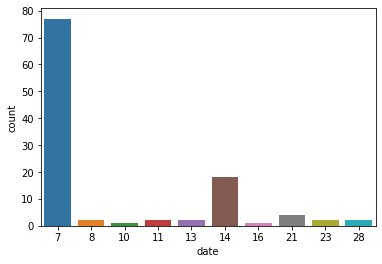

In [ ]:
#number of days in each road
day_counts = traffic.groupby(['road_name'])['date'].nunique()
sns.countplot(day_counts)

In [ ]:
#hours in each day
hour_count = traffic.groupby(['road_name','date'])['time'].nunique()
(hour_count == 24).all()
#looks like there is no missing hours

True

In [ ]:
#insure no duplicates
(traffic.groupby(['road_name','date','time']).nunique() == 1).all()

date              True
road_name         True
time              True
Total Vehicles    True
dtype: bool

In [ ]:
#create time stamp
traffic['timestamp'] = pd.to_datetime(traffic['date'] + ' ' + traffic['time'])
traffic=traffic[['road_name','timestamp','Total Vehicles']].sort_values(['road_name','timestamp'])
traffic.head()

,road_name,timestamp,Total Vehicles
19392,Abbotsford Street,2015-08-21 00:00:00,16
19403,Abbotsford Street,2015-08-21 01:00:00,28
19408,Abbotsford Street,2015-08-21 02:00:00,11
19409,Abbotsford Street,2015-08-21 03:00:00,14
19410,Abbotsford Street,2015-08-21 04:00:00,33


# ARIMA implementation

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
road = traffic[traffic.road_name == 'Abbotsford Street'].reset_index()
train = road.iloc[:int(0.7*len(road))]['Total Vehicles']
valid = road.iloc[int(0.7*len(road)):]['Total Vehicles']

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=1027.143, Time=3.10 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1036.771, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=1035.177, Time=0.95 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=1025.285, Time=2.53 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=1038.769, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[24]             : AIC=inf, Time=5.24 sec
 ARIMA(0,1,1)(0,1,2)[24]             : AIC=inf, Time=9.50 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=1035.149, Time=0.94 sec
 ARIMA(0,1,1)(1,1,2)[24]             : AIC=inf, Time=12.29 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=1023.347, Time=2.16 sec
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,1,2)[24]             : AIC=inf, Time=6.01 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=1033.419, Time=0.57 sec
 ARIMA(0,1,0)(1,1,2)[24]             : AIC=inf, Time=7.14 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=1025.

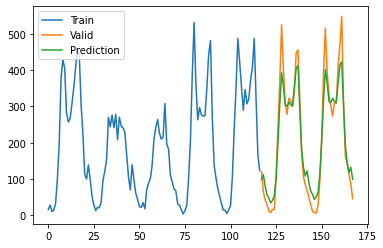

In [ ]:
model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
model.fit(train)

forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.legend()
plt.show()